# Differentiable Predictive Control (DPC) with NeuroMANCER: Double Integrator

This is an interactive notebook based on the python script `double_integrator_DPC_ol_fixed_ref.py`. The NeuroMANCER toolbox can be used to learn closed-loop control policies with Linear State Space Models (LSSM). We demonstrate by learning to stabilize the unstable double integrator:

$$
\mathbf{x}_{k+1}=
\begin{bmatrix}
1.2 & 1.0 \\
0.0 & 1.0
\end{bmatrix}
\mathbf{x}_k+
\begin{bmatrix}
1.0 \\
0.5
\end{bmatrix}
\mathbf{u}_k
$$

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install pyts mlflow plum-dispatch
!pip install git+https://github.com/pnnl/slim.git@master#egg=slim
!pip install git+https://github.com/pnnl/psl.git@master#egg=psl
!pip install git+https://github.com/pnnl/neuromancer.git@master#egg=neuromancer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 

### Import

In [ ]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import slim
import psl

In [ ]:
from neuromancer.activations import activations
from neuromancer import estimators, dynamics
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer import policies
import neuromancer.arg as arg
from neuromancer.dataset import get_sequence_dataloaders
from neuromancer.loss import PenaltyLoss
import neuromancer.simulator as sim

# Dataset

In [ ]:
device = "cpu"
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed);

In [ ]:
# problem dimensions
nx = 2
nu = 1
# number of datapoints
nsim = 10000
# prediction horizon
nsteps = 1

Randomly sample input and output trajectories from a standard normal distribution for training.

In [ ]:
#  we treat states as observables, i.e. Y = X
sequences = {"Y": 3*np.random.randn(nsim, nx)}
nstep_data, loop_data, dims = get_sequence_dataloaders(sequences, nsteps)
train_data, dev_data, test_data = nstep_data
train_loop, dev_loop, test_loop = loop_data

# System Model and Control Policy

In [ ]:
n_layers = 4    # number of hidden layers
nx_hidden = 20  # hidden layer size

## State Estimator

In [ ]:
# Fully observable estimator as identity map: x0 = Yp[-1]
# x_0 = e(Yp)
# Yp = [y_-N, ..., y_0]
estimator = estimators.FullyObservable(
                {**dims, "x0": (nx,)},
                input_keys=["Yp"], name='est')

## Control Policy

In [ ]:
# full state feedback control policy
# [u_0, ..., u_N] = p(x_0)
policy = policies.MLPPolicy(
    {estimator.output_keys[0]: (nx,), 'U': (nsim, nu)},
    nsteps=nsteps,
    linear_map=slim.maps['linear'],
    nonlin=activations['relu'],
    hsizes=[nx_hidden] * n_layers,
    input_keys=[estimator.output_keys[0]],
    name='pol',
)

## Linear Time-Invariant (LTI) SSM

In [ ]:
# x_k+1 = Ax_k + Bu_k
# y_k+1 = Cx_k+1
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])
C = torch.tensor([[1.0, 0.0],
                  [0.0, 1.0]])
dynamics_model = dynamics.LinearSSM(A, B, C, name='mod',
                          input_key_map={'x0': estimator.output_keys[0],
                                          'Uf': policy.output_keys[0]})
dynamics_model.requires_grad_(False)  # fix model parameters

mod(Yf, x0_est, U_pred_pol) -> reg_error_mod, X_pred_mod, Y_pred_mod, fU_mod

# Objectives

In [ ]:
Qx = 5.   # state weight
Qu = 0.1  # control action weight
Qn = 1.   # terminal penalty weight

In [ ]:
u = variable(policy.output_keys[0])
y = variable(dynamics_model.output_keys[2])

# objectives
action_loss = Qu * ((u == 0.) ^ 2)      # control penalty
regulation_loss = Qx * ((y == 0.) ^ 2)  # target position
objectives = [regulation_loss, action_loss]

# set objective names for nicer plot
action_loss.name = "action_loss"
regulation_loss.name = 'state_loss'

In [ ]:
# set objective names for nicer plot
action_loss.name = "action_loss"
regulation_loss.name = 'state_loss'

# Constraints

In [ ]:
umin = -1.
umax = 1.
xmin = -2.
xmax = 2.
xN_min = -0.1
xN_max = 0.1

Q_con_x = 10.   # state constraints penalty weight
Q_con_u = 100.  # input constraints penalty weight

In [ ]:
# constraints
state_lower_bound_penalty = Q_con_x*(y > xmin)
state_upper_bound_penalty = Q_con_x*(y < xmax)
inputs_lower_bound_penalty = Q_con_u*(u > umin)
inputs_upper_bound_penalty = Q_con_u*(u < umax)
terminal_lower_bound_penalty = Qn*(y[:, [-1], :] > xN_min)
terminal_upper_bound_penalty = Qn*(y[:, [-1], :] < xN_max)
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    inputs_lower_bound_penalty,
    inputs_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]

# set constraint names for nicer plot
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
inputs_lower_bound_penalty.name = 'u_min'
inputs_upper_bound_penalty.name = 'u_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'

# DPC Problem
Combine objectives, constraints, and trainable components



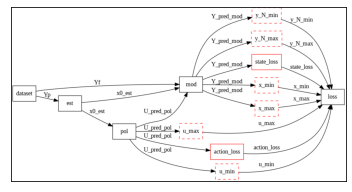

In [ ]:
# data (y_k) -> estimator (x_k) -> policy (u_k) -> dynamics (x_k+1, y_k+1)
components = [estimator, policy, dynamics_model]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
problem.to(device)
# plot computational graph
problem.plot_graph()

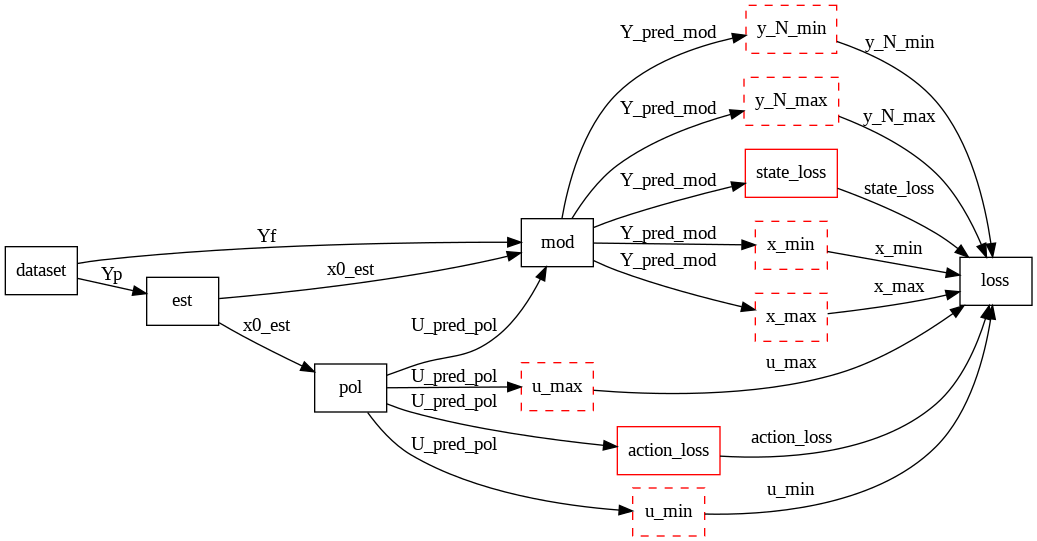

In [ ]:
Image('problem_graph.png')

# Stabilize the System

## Train Control Policy

In [ ]:
lr = 0.001      # step size for gradient descent
epochs = 400    # number of training epochs
warmup = 10     # number of epochs to wait before enacting early stopping policy
patience = 100  # number of epochs with no improvement in eval metric to allow 
                #   before early stopping

In [ ]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_data,
    dev_data,
    test_data,
    optimizer,
    epochs=epochs,
    patience=patience,
    train_metric="nstep_train_loss",
    dev_metric="nstep_dev_loss",
    test_metric="nstep_test_loss",
    eval_metric='nstep_dev_loss',
    warmup=warmup,
)

In [ ]:
# Train closed-loop control policy
best_model = trainer.train()
best_outputs = trainer.test(best_model)

epoch: 0  nstep_train_loss: 93.78044128417969
epoch: 1  nstep_train_loss: 93.58987426757812
epoch: 2  nstep_train_loss: 93.39422607421875
epoch: 3  nstep_train_loss: 93.192626953125
epoch: 4  nstep_train_loss: 92.98308563232422
epoch: 5  nstep_train_loss: 92.76470947265625
epoch: 6  nstep_train_loss: 92.53855895996094
epoch: 7  nstep_train_loss: 92.30409240722656
epoch: 8  nstep_train_loss: 92.0591049194336
epoch: 9  nstep_train_loss: 91.8035888671875
epoch: 10  nstep_train_loss: 91.53752136230469
epoch: 11  nstep_train_loss: 91.26121520996094
epoch: 12  nstep_train_loss: 90.97489929199219
epoch: 13  nstep_train_loss: 90.6783447265625
epoch: 14  nstep_train_loss: 90.37018585205078
epoch: 15  nstep_train_loss: 90.04766845703125
epoch: 16  nstep_train_loss: 89.70755767822266
epoch: 17  nstep_train_loss: 89.34925842285156
epoch: 18  nstep_train_loss: 88.97285461425781
epoch: 19  nstep_train_loss: 88.57914733886719
epoch: 20  nstep_train_loss: 88.16817474365234
epoch: 21  nstep_train_loss:

# Test Closed-Loop System

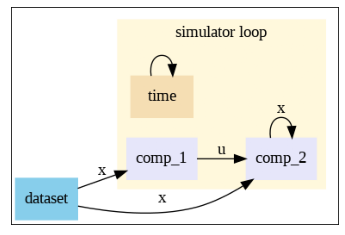

In [ ]:
policy_cl = sim.ControllerPytorch(policy=policy.net,
                                  nsteps=nsteps, input_keys=['x'])
system_cl = sim.DynamicsLinSSM(A.numpy(), B.numpy(), C.numpy())
components = [policy_cl, system_cl]
cl_sim = sim.SystemSimulator(components)
cl_sim.plot_graph()

## Plot Closed-Loop Trajectories

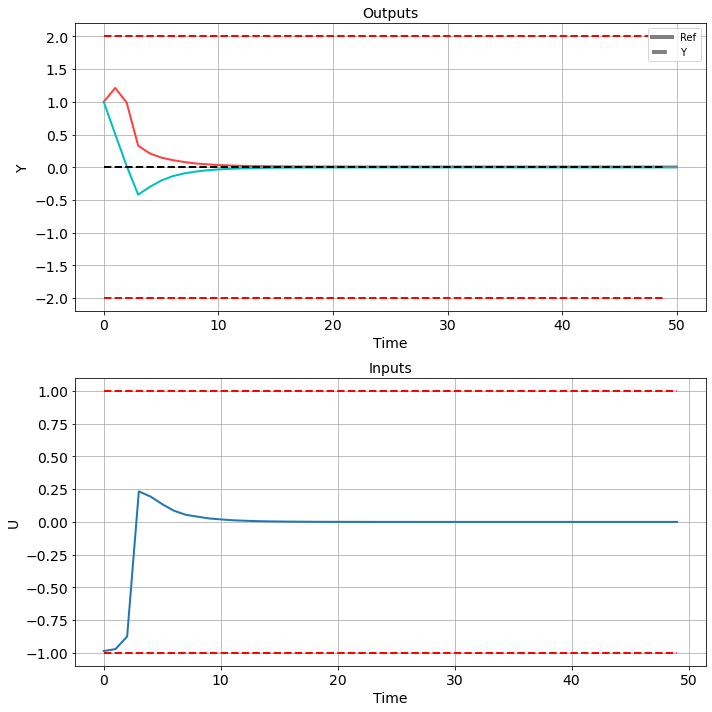

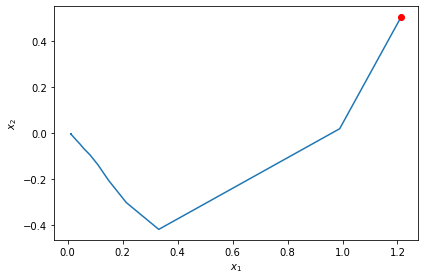

In [ ]:
data = {'x': np.ones(nx)}
trajectories = cl_sim.simulate(nsim=50, data_init=data)

Umin = umin * np.ones([trajectories['y'].shape[0], 1])
Umax = umax * np.ones([trajectories['y'].shape[0], 1])
Ymin = xmin * np.ones([trajectories['y'].shape[0], 1])
Ymax = xmax * np.ones([trajectories['y'].shape[0], 1])
R = np.zeros([trajectories['y'].shape[0], 1])
psl.plot.pltCL(Y=trajectories['x'], U=trajectories['u'], R=R,
                Umin=Umin, Umax=Umax, Ymin=Ymin, Ymax=Ymax)
fig = plt.gcf()
fig.set_size_inches((10,10))
fig.tight_layout()
psl.plot.pltPhase(X=trajectories['y'])